In [1]:
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

 97% 585M/604M [00:04<00:00, 194MB/s]
100% 604M/604M [00:04<00:00, 137MB/s]


In [4]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/z-by-hp-unlocked-challenge-3-signal-processing.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
!pip install tensorflow tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.34.0
    Uninstalling tensorflow-io-gcs-filesystem-0.34.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.34.0


In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [7]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [8]:
CAPUCHIN_FILE

'data/Parsed_Capuchinbird_Clips/XC3776-3.wav'

In [9]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [10]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

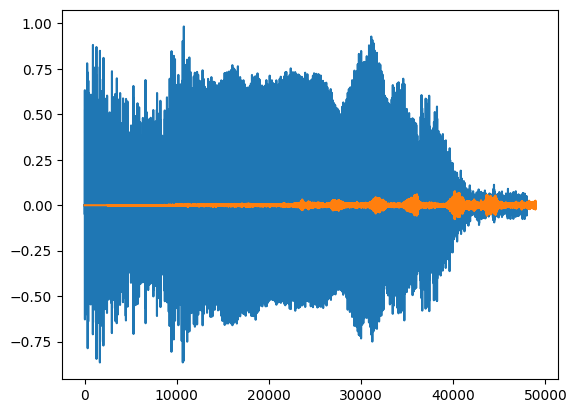

In [11]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create Tensorflow Dataset

In [12]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [13]:
POS

'data/Parsed_Capuchinbird_Clips'

In [14]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [15]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC168899-0.wav'

# Add labels and Combine Positive and Negative Samples

In [16]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# Exploratory Analysis - Calculate Mean, Min, Max

In [17]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [18]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [19]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

# Preprocessing Function to Convert to Spectogram

In [20]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [28]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [29]:
spectogram, label = preprocess(filepath, label)

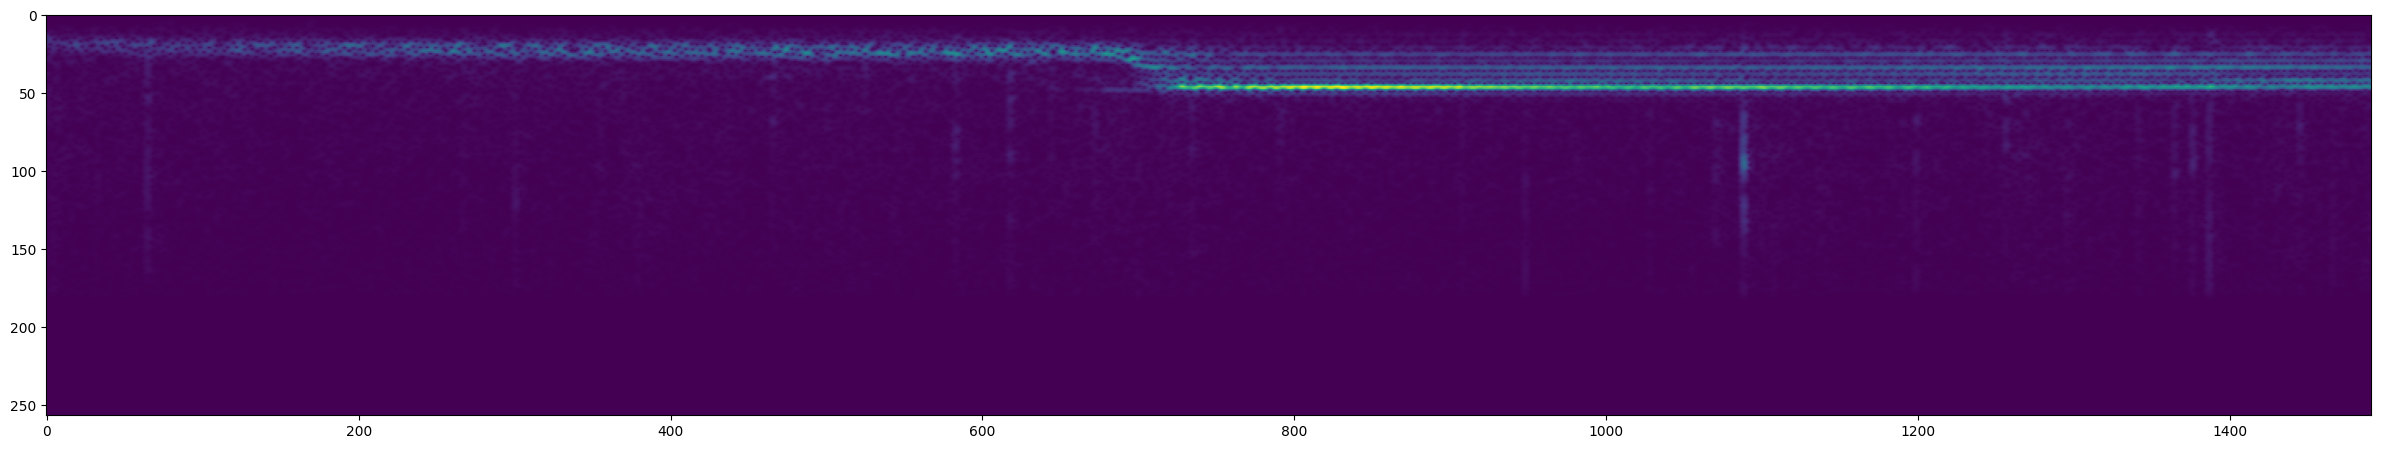

In [30]:
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

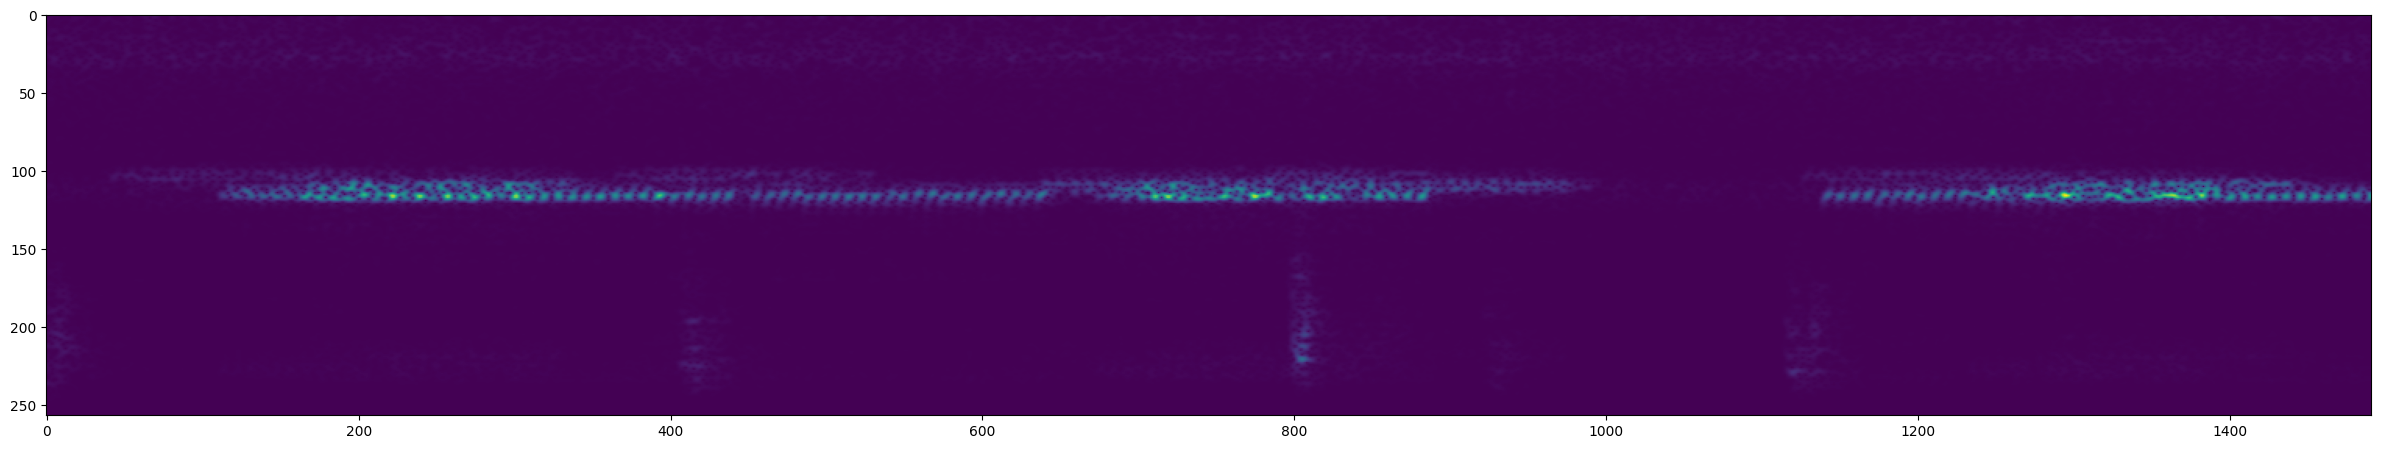

In [24]:
filepath, label = negatives.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

# Create a Tensorflow Data Pipeline

In [31]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [32]:
len(data)

51

In [33]:
train = data.take(36)
test = data.skip(36).take(15)

# Build Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [35]:
from keras import backend as K
K.clear_session()

In [41]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile(optimizer = 'Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [44]:
hist = model.fit(train, epochs = 4, validation_data = test)

Epoch 1/4
36/36 [==============================] - 8s 104ms/step - loss: 0.5147 - recall_1: 0.8944 - precision_1: 0.8045 - val_loss: 0.0331 - val_recall_1: 0.9649 - val_precision_1: 1.0000
Epoch 2/4
36/36 [==============================] - 3s 89ms/step - loss: 0.0463 - recall_1: 0.9808 - precision_1: 0.9871 - val_loss: 0.0122 - val_recall_1: 1.0000 - val_precision_1: 0.9833
Epoch 3/4
36/36 [==============================] - 3s 94ms/step - loss: 0.0091 - recall_1: 1.0000 - precision_1: 0.9934 - val_loss: 0.0040 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 3s 96ms/step - loss: 0.0153 - recall_1: 0.9873 - precision_1: 1.0000 - val_loss: 8.9288e-04 - val_recall_1: 1.0000 - val_precision_1: 1.0000


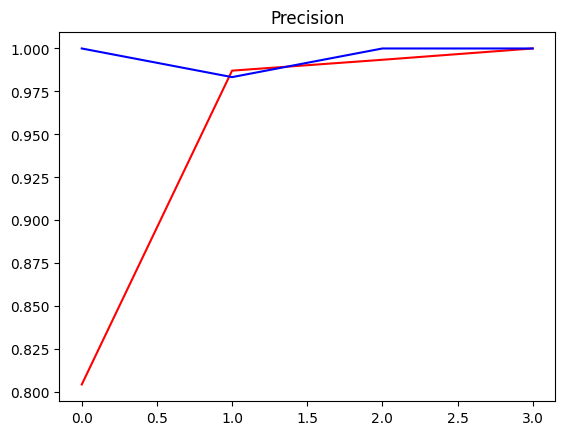

In [46]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

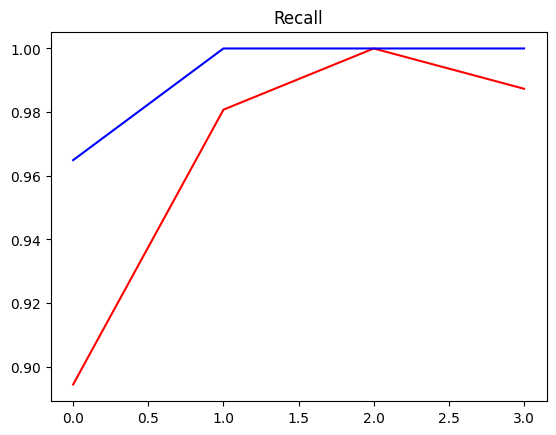

In [47]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# Make Predictions on a Single Clip

In [48]:
X_test, Y_test = test.as_numpy_iterator().next()

In [49]:
Y_hat = model.predict(X_test)

1/1 [==============================] - 0s 223ms/step


In [50]:
Y_hat

array([[9.5074612e-01],
       [2.7117474e-22],
       [9.9999762e-01],
       [4.4044883e-15],
       [1.6573161e-15],
       [4.7421919e-15],
       [7.1544505e-06],
       [1.0000000e+00],
       [1.0321634e-06],
       [1.6210069e-07],
       [1.0000000e+00],
       [1.1396513e-03],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [7.2481307e-06]], dtype=float32)

In [51]:
Y_hat = [1 if pred > 0.5 else 0 for pred in Y_hat]

In [52]:
Y_hat

[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]

In [54]:
Y_test.astype(int)

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0])

# Load up MP3 files

In [55]:
def load_mp3_16k_mono(filename):
  res = tfio.audio.AudioIOTensor(filename)
  # Convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis = 1)/2
  # Extract simple rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  # Resample to 16 Khz
  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)
  return wav

In [56]:
mp3 = '/content/data/Forest Recordings/recording_00.mp3'

In [57]:
wav = load_mp3_16k_mono(mp3)

In [59]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [60]:
samples, index = audio_slices.as_numpy_iterator().next()

In [61]:
len(audio_slices)

60

In [62]:
samples.shape

(1, 48000)

In [63]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [66]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [71]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat]

1/1 [==============================] - 1s 723ms/step


In [72]:
len(yhat)

60

In [73]:
yhat

[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# Group Consecutive Detections

In [70]:
from itertools import groupby

In [75]:
yhat = [key for key, group in groupby(yhat)]

In [76]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [77]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

# Final results

In [78]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 0s 390ms/step


In [80]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_34.mp3': [0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_65.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_93.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0],
 'recording_60.mp3': [0,
  0,
  0,
  

In [81]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_34.mp3': 4,
 'recording_65.mp3': 4,
 'recording_93.mp3': 5,
 'recording_60.mp3': 5,
 'recording_23.mp3': 5,
 'recording_49.mp3': 0,
 'recording_05.mp3': 0,
 'recording_07.mp3': 2,
 'recording_88.mp3': 0,
 'recording_98.mp3': 21,
 'recording_32.mp3': 2,
 'recording_91.mp3': 0,
 'recording_68.mp3': 1,
 'recording_94.mp3': 3,
 'recording_67.mp3': 0,
 'recording_30.mp3': 3,
 'recording_50.mp3': 0,
 'recording_11.mp3': 3,
 'recording_18.mp3': 2,
 'recording_21.mp3': 1,
 'recording_69.mp3': 1,
 'recording_73.mp3': 0,
 'recording_45.mp3': 3,
 'recording_75.mp3': 1,
 'recording_97.mp3': 4,
 'recording_02.mp3': 0,
 'recording_74.mp3': 0,
 'recording_54.mp3': 1,
 'recording_15.mp3': 2,
 'recording_41.mp3': 0,
 'recording_90.mp3': 0,
 'recording_53.mp3': 0,
 'recording_70.mp3': 3,
 'recording_00.mp3': 5,
 'recording_35.mp3': 0,
 'recording_25.mp3': 2,
 'recording_89.mp3': 3,
 'recording_52.mp3': 0,
 'recording_22.mp3': 2,
 'recording_96.mp3': 1,
 'recording_38.mp3': 12,
 'recording_56